# Анализ данных и препроцессинг.


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


# **Иследуем набор данных**

In [52]:
#загрузка данных 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Получив информацию о наших данных, выведем фактические данные.

In [53]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **Бивариантный анализ и категориальная корреляция**


In [54]:
#делим данные на 2 типа.
numerical_data = train.select_dtypes(include='number')
categorical_data = train.select_dtypes(include='object')
print("Количество признаков в числовых данных:",len(numerical_data.columns))
print("Количество признаков в категориальных данных:",len(categorical_data.columns))

Количество признаков в числовых данных: 38
Количество признаков в категориальных данных: 43


**Посмотрим на корреляцию между числовыми характеристиками.**

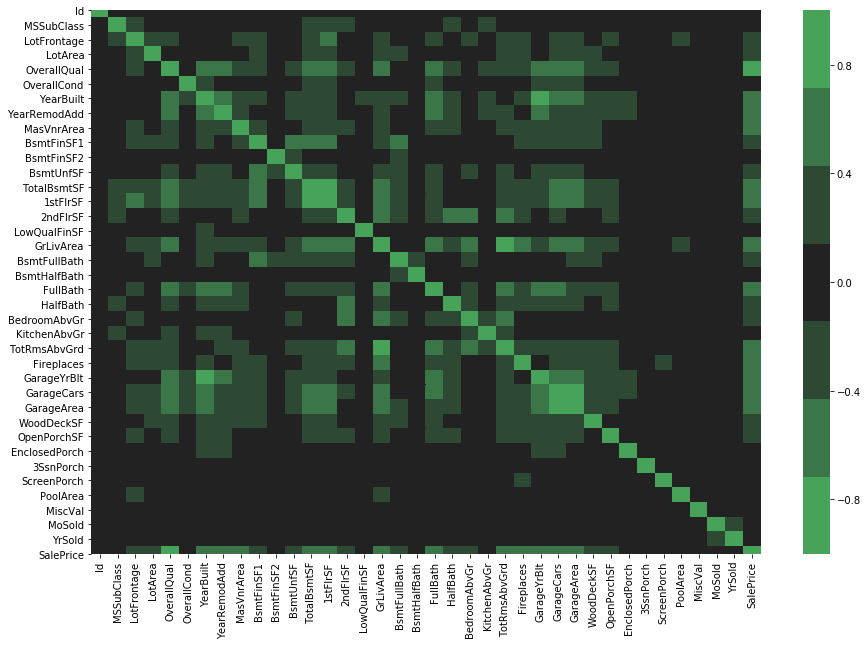

In [55]:
numerical_corr = numerical_data.corr()
#numerical_corr.sort_values(by='SalePrice',ascending=False,inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(numerical_corr, cmap=sns.diverging_palette(133, 133, l=60, n=7, center="dark"), vmin=-1, vmax=1)

**Посмотрим на корреляцию между категориальными признаками и SalePrice. .**


Наиболее классической мерой "correlation" между номинальной и интервальной(числовой "numeric") переменными является Eta, также называемое корреляционным отношением. Eta можно рассматривать как симметричную ассоциативную меру.

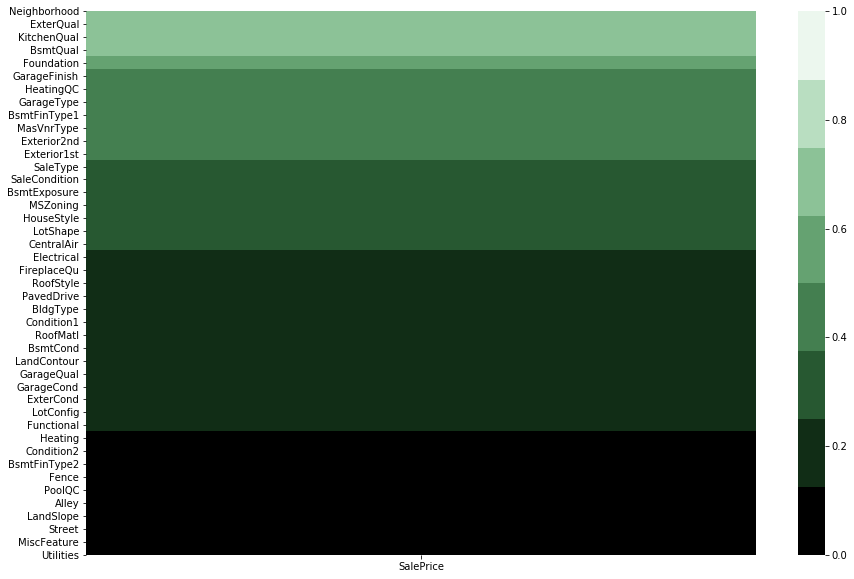

In [56]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

lis = []
for i in categorical_data.columns:
    relation = correlation_ratio(categorical_data[i], numerical_data['SalePrice'])
    lis.append(relation)
    
indexes = list(categorical_data.columns)
categorical_corr = pd.DataFrame(lis, columns=['SalePrice'], index=indexes)
categorical_corr.sort_values(by='SalePrice',ascending=False,inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(categorical_corr,cmap=sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True),vmin=0,vmax=1)

График, который показывает корреляцию между каждым категориальным признаком и SalePrice.

**Определим, какие функции являются наиболее значимыми в прогнозировании SalePrice.**


In [57]:
numerical_corr.sort_values(by='SalePrice',ascending=False,inplace=True)
display(numerical_corr['SalePrice'],categorical_corr['SalePrice'])

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Neighborhood     0.738630
ExterQual        0.690933
KitchenQual      0.675721
BsmtQual         0.664356
Foundation       0.506328
GarageFinish     0.498963
HeatingQC        0.442154
GarageType       0.438726
BsmtFinType1     0.432828
MasVnrType       0.431419
Exterior2nd      0.392211
Exterior1st      0.390862
SaleType         0.370523
SaleCondition    0.368100
BsmtExposure     0.356166
MSZoning         0.327963
HouseStyle       0.293790
LotShape         0.276362
CentralAir       0.251328
Electrical       0.244278
FireplaceQu      0.243738
RoofStyle        0.240201
PavedDrive       0.233537
BldgType         0.185833
Condition1       0.180640
RoofMatl         0.177237
BsmtCond         0.167398
LandContour      0.160605
GarageQual       0.158899
GarageCond       0.158663
ExterCond        0.153680
LotConfig        0.144981
Functional       0.128376
Heating          0.120155
Condition2       0.099495
BsmtFinType2     0.095834
Fence            0.072851
PoolQC           0.066318
Alley       

# **Удаления данных**

In [58]:
updated_data = pd.concat([train,test],axis=0,sort=False)
updated_data = updated_data.drop(numerical_corr[numerical_corr['SalePrice']<0.3].index,1)
updated_data = updated_data.drop(categorical_corr[categorical_corr['SalePrice']<0.3].index,1)

In [59]:
print(updated_data.shape)

(2919, 35)


**Используем графики для визуализации данных.**

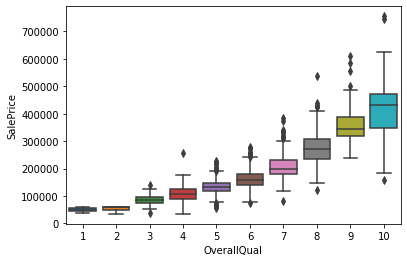

In [60]:
x_variable = 'OverallQual'
sns.boxplot(x=x_variable,y='SalePrice',data=updated_data)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117]), <a list of 118 Text xticklabel objects>)

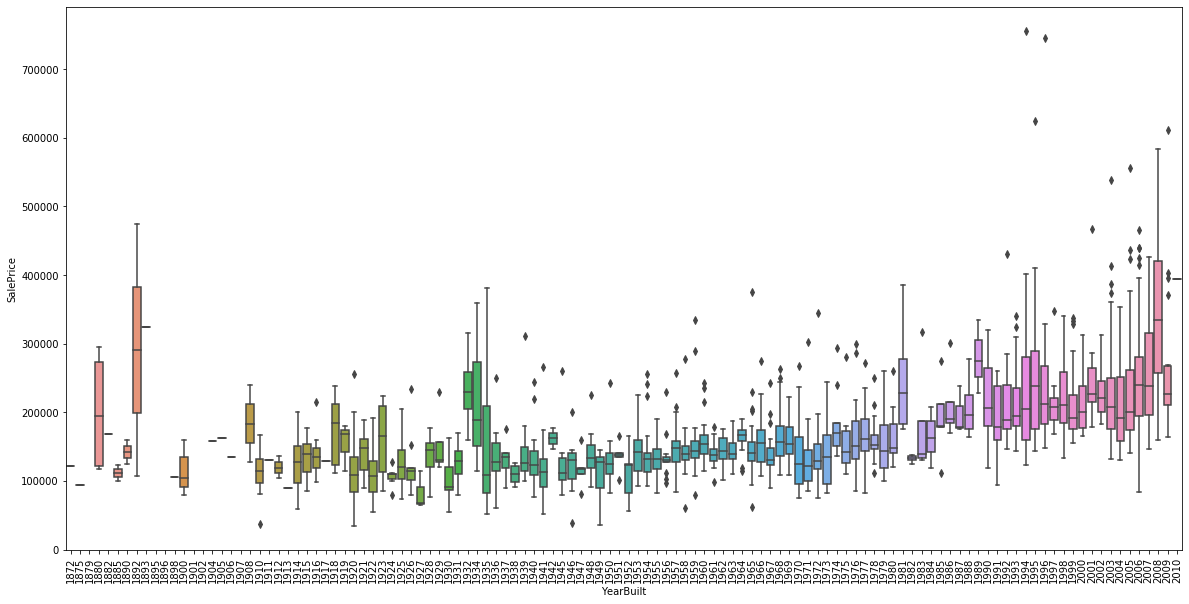

In [61]:
x_variable = 'YearBuilt'
plt.figure(figsize=(20,10))
sns.boxplot(x=x_variable,y='SalePrice',data=updated_data)
plt.xticks(rotation=90)

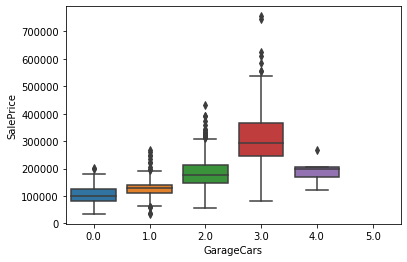

In [62]:
x_variable = 'GarageCars'
sns.boxplot(x=x_variable,y='SalePrice',data=updated_data)

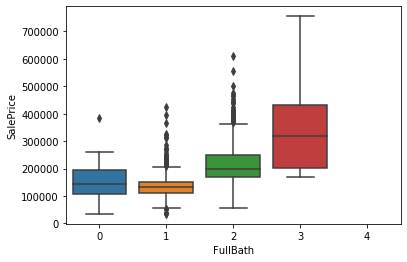

In [63]:
x_variable = 'FullBath'
sns.boxplot(x=x_variable,y='SalePrice',data=updated_data)

/Users/caesar_julia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/caesar_julia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


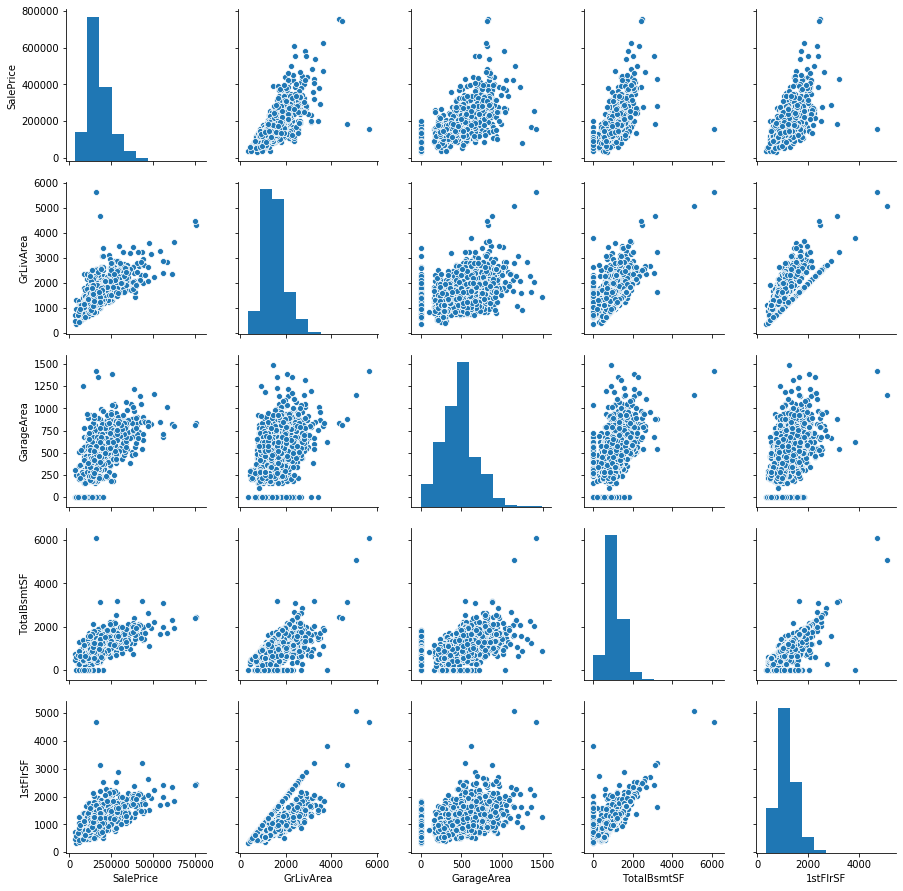

In [64]:
categories = ['SalePrice','GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF']
sns.pairplot(updated_data[categories])

Посмотрим распределения данных.

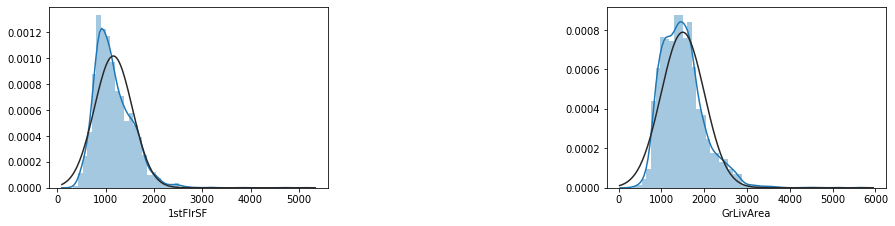

In [66]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=1, wspace=1)
ax = fig.add_subplot(221)
sns.distplot(updated_data['1stFlrSF'],fit=norm)
ax = fig.add_subplot(222)
sns.distplot(updated_data['GrLivArea'],fit=norm)
plt.show()

Применив **log (1 + x)** преобразование можем справиться с асимметрией.

In [67]:
updated_data['GrLivArea'] = np.log1p(updated_data['GrLivArea'])
updated_data['1stFlrSF'] = np.log1p(updated_data['1stFlrSF'])

Проверим работоспособность.

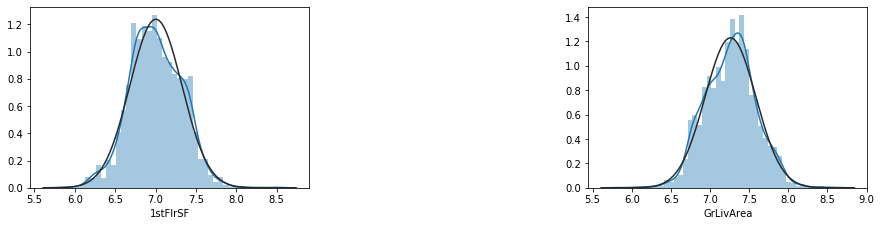

In [68]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=1, wspace=1)
ax = fig.add_subplot(221)
sns.distplot(updated_data['1stFlrSF'],fit=norm)
ax = fig.add_subplot(222)
sns.distplot(updated_data['GrLivArea'],fit=norm)
plt.show()

### **Работа с выбросами**

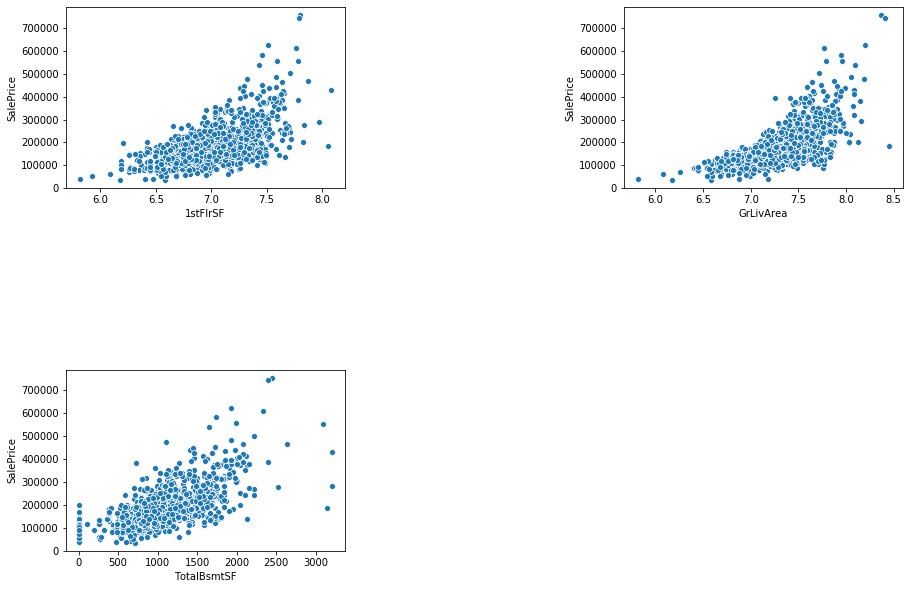

In [69]:
updated_data = updated_data.drop(updated_data[updated_data['GrLivArea']>4600].index)
updated_data = updated_data.drop(updated_data[updated_data['TotalBsmtSF']>5000].index)
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=1, wspace=1)
ax = fig.add_subplot(221)
sns.scatterplot(x='1stFlrSF',y='SalePrice',data=updated_data)
ax = fig.add_subplot(222)
sns.scatterplot(x='GrLivArea',y='SalePrice',data=updated_data)
ax = fig.add_subplot(223)
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=updated_data)
plt.show()

Удаление выбросов может помочь повысить производительность и точность алгоритма. Посмотрим есть ли в наших данных пропущенные значения.

In [70]:
missing_data = (updated_data.isnull().sum()/len(updated_data)).sort_values(ascending=False)
missing_data = missing_data[missing_data>0]
print(missing_data)

SalePrice       0.499828
LotFrontage     0.166724
GarageFinish    0.054545
GarageYrBlt     0.054545
GarageType      0.053859
BsmtExposure    0.028130
BsmtQual        0.027787
BsmtFinType1    0.027101
MasVnrType      0.008233
MasVnrArea      0.007890
MSZoning        0.001372
SaleType        0.000343
TotalBsmtSF     0.000343
BsmtFinSF1      0.000343
Exterior1st     0.000343
GarageCars      0.000343
GarageArea      0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
dtype: float64


we can see that our data has a few missing values, so lets fill these missing values with the most common value approach i.e we will fill the missing value of a certain feature with value that appears highest number of times in our dataset. 

In [71]:
for i in missing_data.index:
    print(i+':\t',eval('updated_data.'+i+'.mode()[0]'))
    

SalePrice:	 140000.0
LotFrontage:	 60.0
GarageFinish:	 Unf
GarageYrBlt:	 2005.0
GarageType:	 Attchd
BsmtExposure:	 No
BsmtQual:	 TA
BsmtFinType1:	 Unf
MasVnrType:	 None
MasVnrArea:	 0.0
MSZoning:	 RL
SaleType:	 WD
TotalBsmtSF:	 0.0
BsmtFinSF1:	 0.0
Exterior1st:	 VinylSd
GarageCars:	 2.0
GarageArea:	 0.0
KitchenQual:	 TA
Exterior2nd:	 VinylSd


Заполним пропущеные значения.

In [73]:
updated_data['LotFrontage'] = updated_data['LotFrontage'].fillna(60.0)
updated_data['GarageFinish'] = updated_data['GarageFinish'].fillna('Unf')
updated_data['GarageYrBlt'] = updated_data['GarageYrBlt'].fillna(2005.0)
updated_data['GarageType'] = updated_data['GarageType'].fillna('Attchd')
updated_data['BsmtExposure'] = updated_data['BsmtExposure'].fillna('No')
updated_data['BsmtQual'] = updated_data['BsmtQual'].fillna('TA')
updated_data['BsmtFinType1'] = updated_data['BsmtFinType1'].fillna('Unf')
updated_data['MasVnrType'] = updated_data['MasVnrType'].fillna('None')
updated_data['MSZoning'] = updated_data['MSZoning'].fillna('RL')
updated_data['MasVnrArea'] = updated_data['MasVnrArea'].fillna(0.0)
updated_data['TotalBsmtSF'] = updated_data['TotalBsmtSF'].fillna(0.0)
updated_data['SaleType'] = updated_data['SaleType'].fillna('WD')
updated_data['BsmtFinSF1'] = updated_data['BsmtFinSF1'].fillna(0.0)
updated_data['Exterior1st'] = updated_data['Exterior1st'].fillna('VinylSd')
updated_data['GarageCars'] = updated_data['GarageCars'].fillna(2.0)
updated_data['GarageArea'] = updated_data['GarageArea'].fillna('-inf')
updated_data['KitchenQual'] = updated_data['KitchenQual'].fillna('TA')
updated_data['Exterior2nd'] = updated_data['Exterior2nd'].fillna('VinylSd')

In [78]:
updated_data = pd.get_dummies(updated_data)

# **Predictive**
Создадим тестовые и обучающие наборы данных.

In [84]:
x_train = updated_data.iloc[:len(train)-4, :]
del x_train['SalePrice']
y_train = train.SalePrice.iloc[:len(train)-4]
x_test = updated_data.iloc[len(train)-4:, :]
del x_test['SalePrice']

Предскажем SalePrice.

Прогноз с помощью линейной регрессии.

In [85]:
lm = LinearRegression()
model2 = lm.fit(x_train, y_train)
predict2 = model2.predict(x_train)
accuracy2 = r2_score(y_train,predict2)
print('Accuracy:'+str(accuracy2)+'\nMean-Absolute-Error:'+str(mean_absolute_error(predict2, y_train)))

Accuracy:0.7362351186266276
Mean-Absolute-Error:27489.05374313187


Прогноз с помощью kernel regression.

In [89]:
kridge = KernelRidge()
model3 = kridge.fit(x_train,y_train)
predict3 = model3.predict(x_train)
accuracy3 = r2_score(y_train,predict2)
print('Accuracy:'+str(accuracy3)+'\nMean-Absolute-Error:'+str(mean_absolute_error(predict3, y_train)))

Accuracy:0.7362351186266276
Mean-Absolute-Error:26723.271959912647


Прогноз с помощью Gradient Boosting for regression.

In [90]:
gbe = GradientBoostingRegressor()
model4 = gbe.fit(x_train,y_train)
predict4 = model4.predict(x_train)
accuracy4 = r2_score(y_train,predict2)
print('Accuracy:'+str(accuracy4)+'\nMean-Absolute-Error:'+str(mean_absolute_error(predict4, y_train)))

Accuracy:0.7362351186266276
Mean-Absolute-Error:26739.285224706866
